## **ta** module in Python

In [19]:
import pandas as pd
from ta.utils import dropna
from ta.volatility import BollingerBands


# Load datas
df = pd.read_csv('./data/bitcoin_price.csv', sep=',')

# Clean NaN values
df = dropna(df)

# Initialize Bollinger Bands Indicator
indicator_bb = BollingerBands(close=df["Close"], window=20, window_dev=2)  # a BollingerBands class instance is initialized

# Add Bollinger Bands features
df['bb_bbm'] = indicator_bb.bollinger_mavg()
df['bb_bbh'] = indicator_bb.bollinger_hband()
df['bb_bbl'] = indicator_bb.bollinger_lband()

# Add Bollinger Band high indicator
df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()

# Add Bollinger Band low indicator
df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()

# Add Width Size Bollinger Bands
df['bb_bbw'] = indicator_bb.bollinger_wband()

# Add Percentage Bollinger Bands
df['bb_bbp'] = indicator_bb.bollinger_pband()

# Show dataframe
df

,Date,Open,High,Low,Close,Volume,Market Cap,bb_bbm,bb_bbh,bb_bbl,bb_bbhi,bb_bbli,bb_bbw,bb_bbp
0,"Sep 05, 2017",4228.29,4427.84,3998.11,4376.53,"2,697,970,000","69,954,400,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,"Sep 04, 2017",4591.63,4591.63,4108.40,4236.31,"2,987,330,000","75,955,500,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,"Sep 03, 2017",4585.27,4714.08,4417.59,4582.96,"1,933,190,000","75,841,700,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,"Sep 02, 2017",4901.42,4975.04,4469.24,4578.77,"2,722,140,000","81,060,600,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,"Sep 01, 2017",4701.76,4892.01,4678.53,4892.01,"2,599,080,000","77,748,400,000",NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000",115.2350,127.593745,102.876255,0.0,0.0,21.449638,0.094417
1588,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000",114.9405,126.828244,103.052756,0.0,0.0,20.685040,0.586202
1589,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000",115.7905,131.418458,100.162542,1.0,0.0,26.993506,1.242563
1590,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000",116.9180,136.837037,96.998963,1.0,0.0,34.073516,1.193357


<AxesSubplot:>

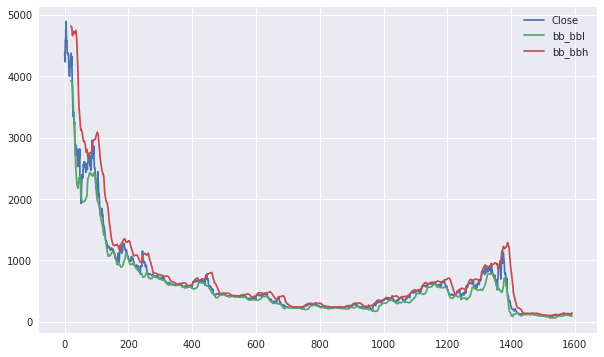

In [20]:
# plot with pandas method
df[["Close", "bb_bbl", "bb_bbh"]].plot(figsize=(10, 6))

## Average Directional Index (ADX)

In [21]:
from ta.utils import IndicatorMixin, _ema, _get_min_max
import numpy as np
import pandas as pd


class ADXIndicator(IndicatorMixin):
    """Average Directional Movement Index (ADX)
    The Plus Directional Indicator (+DI) and Minus Directional Indicator (-DI)
    are derived from smoothed averages of these differences, and measure trend
    direction over time. These two indicators are often referred to
    collectively as the Directional Movement Indicator (DMI).
    The Average Directional Index (ADX) is in turn derived from the smoothed
    averages of the difference between +DI and -DI, and measures the strength
    of the trend (regardless of direction) over time.
    Using these three indicators together, chartists can determine both the
    direction and strength of the trend.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_directional_index_adx
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        window(int): n period.
        fillna(bool): if True, fill nan values.
    """

    def __init__(
        self,
        high: pd.Series,
        low: pd.Series,
        close: pd.Series,
        window: int = 14,
        fillna: bool = False,
    ):
        self._high = high
        self._low = low
        self._close = close
        self._window = window
        self._fillna = fillna
        self._run()

    def _run(self):
        if self._window == 0:
            raise ValueError("window may not be 0")

        close_shift = self._close.shift(1)
        pdm = _get_min_max(self._high, close_shift, "max")
        pdn = _get_min_max(self._low, close_shift, "min")
        diff_directional_movement = pdm - pdn

        self._trs_initial = np.zeros(self._window - 1)
        self._trs = np.zeros(len(self._close) - (self._window - 1))
        self._trs[0] = diff_directional_movement.dropna()[
            0 : self._window  # noqa E203
        ].sum()  # noqa E203
        diff_directional_movement = diff_directional_movement.reset_index(drop=True)

        for i in range(1, len(self._trs) - 1):
            self._trs[i] = (
                self._trs[i - 1]
                - (self._trs[i - 1] / float(self._window))
                + diff_directional_movement[self._window + i]
            )

        diff_up = self._high - self._high.shift(1)
        diff_down = self._low.shift(1) - self._low
        pos = abs(((diff_up > diff_down) & (diff_up > 0)) * diff_up)
        neg = abs(((diff_down > diff_up) & (diff_down > 0)) * diff_down)

        self._dip = np.zeros(len(self._close) - (self._window - 1))
        self._dip[0] = pos.dropna()[0 : self._window].sum()  # noqa E203

        pos = pos.reset_index(drop=True)

        for i in range(1, len(self._dip) - 1):
            self._dip[i] = (
                self._dip[i - 1]
                - (self._dip[i - 1] / float(self._window))
                + pos[self._window + i]
            )

        self._din = np.zeros(len(self._close) - (self._window - 1))
        self._din[0] = neg.dropna()[0 : self._window].sum()  # noqa E203

        neg = neg.reset_index(drop=True)

        for i in range(1, len(self._din) - 1):
            self._din[i] = (
                self._din[i - 1]
                - (self._din[i - 1] / float(self._window))
                + neg[self._window + i]
            )

    def adx(self) -> pd.Series:
        """Average Directional Index (ADX)
        Returns:
            pandas.Series: New feature generated.tr
        """
        dip = np.zeros(len(self._trs))

        for idx, value in enumerate(self._trs):
            dip[idx] = 100 * (self._dip[idx] / value)

        din = np.zeros(len(self._trs))

        for idx, value in enumerate(self._trs):
            din[idx] = 100 * (self._din[idx] / value)

        directional_index = 100 * np.abs((dip - din) / (dip + din))

        adx_series = np.zeros(len(self._trs))
        adx_series[self._window] = directional_index[
            0 : self._window  # noqa E203
        ].mean()

        for i in range(self._window + 1, len(adx_series)):
            adx_series[i] = (
                (adx_series[i - 1] * (self._window - 1)) + directional_index[i - 1]
            ) / float(self._window)

        adx_series = np.concatenate((self._trs_initial, adx_series), axis=0)
        adx_series = pd.Series(data=adx_series, index=self._close.index)

        adx_series = self._check_fillna(adx_series, value=20)
        return pd.Series(adx_series, name="adx")

    def adx_pos(self) -> pd.Series:
        """Plus Directional Indicator (+DI)
        Returns:
            pandas.Series: New feature generated.
        """
        dip = np.zeros(len(self._close))
        for i in range(1, len(self._trs) - 1):
            dip[i + self._window] = 100 * (self._dip[i] / self._trs[i])

        adx_pos_series = self._check_fillna(
            pd.Series(dip, index=self._close.index), value=20
        )
        return pd.Series(adx_pos_series, name="adx_pos")

    def adx_neg(self) -> pd.Series:
        """Minus Directional Indicator (-DI)
        Returns:
            pandas.Series: New feature generated.
        """
        din = np.zeros(len(self._close))
        for i in range(1, len(self._trs) - 1):
            din[i + self._window] = 100 * (self._din[i] / self._trs[i])

        adx_neg_series = self._check_fillna(
            pd.Series(din, index=self._close.index), value=20
        )
        return pd.Series(adx_neg_series, name="adx_neg")

In [22]:
# Initialize ADX class instance
df = pd.read_csv('./data/bitcoin_price.csv', sep=',')
ADX_btc = ADXIndicator(df["High"], df["Low"], df["Close"], window=14, fillna=True)
df["ADX"] = ADX_btc.adx()
df

/tmp/ipykernel_7148/524288521.py:101: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/tmp/ipykernel_7148/524288521.py:106: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)


,Date,Open,High,Low,Close,Volume,Market Cap,ADX
0,"Sep 05, 2017",4228.29,4427.84,3998.11,4376.53,"2,697,970,000","69,954,400,000",0.000000
1,"Sep 04, 2017",4591.63,4591.63,4108.40,4236.31,"2,987,330,000","75,955,500,000",0.000000
2,"Sep 03, 2017",4585.27,4714.08,4417.59,4582.96,"1,933,190,000","75,841,700,000",0.000000
3,"Sep 02, 2017",4901.42,4975.04,4469.24,4578.77,"2,722,140,000","81,060,600,000",0.000000
4,"Sep 01, 2017",4701.76,4892.01,4678.53,4892.01,"2,599,080,000","77,748,400,000",0.000000
...,...,...,...,...,...,...,...,...
1587,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000",20.464788
1588,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000",19.358570
1589,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000",18.854683
1590,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000",18.427891


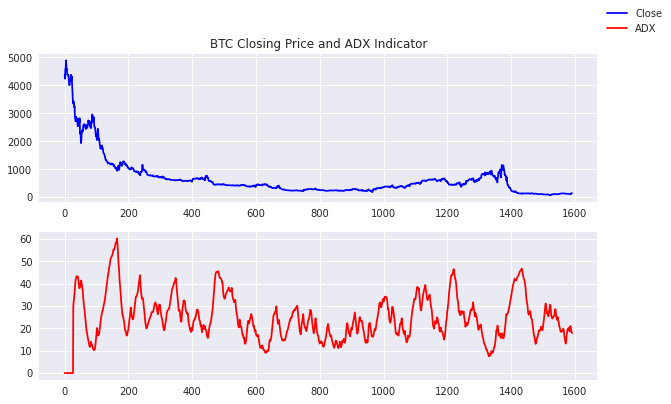

In [23]:
import matplotlib.pyplot as plt
# Plot the ADX indicator
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(10, 6)
axs[0].plot(df["Close"], label="Close", color="blue")
axs[0].set_title("BTC Closing Price and ADX Indicator")
axs[1].plot(df["ADX"], label="ADX", color="red")
fig.legend()

## MACD

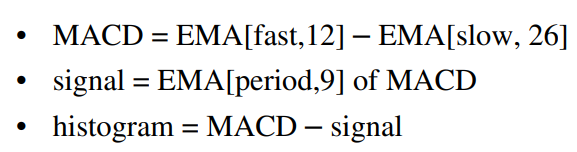
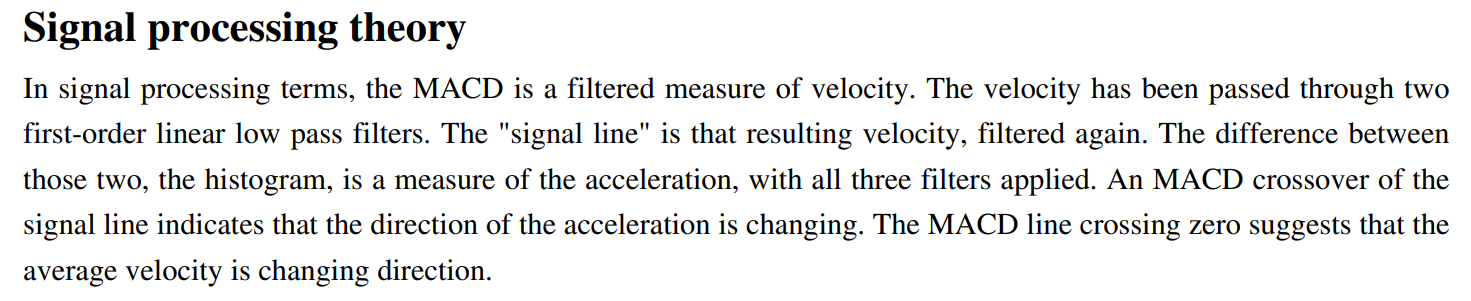

In [24]:
class MACD(IndicatorMixin):
    """Moving Average Convergence Divergence (MACD)
    Is a trend-following momentum indicator that shows the relationship between
    two moving averages of prices.
    Args:
        close(pandas.Series): dataset 'Close' column.
        window_fast(int): n period short-term.
        window_slow(int): n period long-term.
        window_sign(int): n period to signal.
        fillna(bool): if True, fill nan values.
    """

    def __init__(
        self,
        close: pd.Series,
        window_slow: int = 26,
        window_fast: int = 12,
        window_sign: int = 9,
        fillna: bool = False,
    ):
        self._close = close
        self._window_slow = window_slow
        self._window_fast = window_fast
        self._window_sign = window_sign
        self._fillna = fillna
        self._run()

    def _run(self):
        self._emafast = _ema(self._close, self._window_fast, self._fillna)
        self._emaslow = _ema(self._close, self._window_slow, self._fillna)
        self._macd = self._emafast - self._emaslow
        self._macd_signal = _ema(self._macd, self._window_sign, self._fillna)
        self._macd_diff = self._macd - self._macd_signal

    def macd(self) -> pd.Series:
        """MACD Line
        Returns:
            pandas.Series: New feature generated.
        """
        macd_series = self._check_fillna(self._macd, value=0)
        return pd.Series(
            macd_series, name=f"MACD_{self._window_fast}_{self._window_slow}"
        )

    def macd_signal(self) -> pd.Series:
        """Signal Line
        Returns:
            pandas.Series: New feature generated.
        """

        macd_signal_series = self._check_fillna(self._macd_signal, value=0)
        return pd.Series(
            macd_signal_series,
            name=f"MACD_sign_{self._window_fast}_{self._window_slow}",
        )

    def macd_diff(self) -> pd.Series:
        """MACD Histogram
        Returns:
            pandas.Series: New feature generated.
        """
        macd_diff_series = self._check_fillna(self._macd_diff, value=0)
        return pd.Series(
            macd_diff_series, name=f"MACD_diff_{self._window_fast}_{self._window_slow}"
        )

In [25]:
df = pd.read_csv('./data/bitcoin_price.csv', sep=',')

MACD_btc = MACD(df["Close"][-50:], fillna=True)  # take last 50 values
df["macd"] = MACD_btc.macd()
df["macd_hist"] = MACD_btc.macd_diff()
df["macd_signal"] = MACD_btc.macd_signal()

df

/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)
/home/sscf/.pyenv/versions/3.10.5/lib/python3.10/site-packages/ta/utils.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  series = series_output.fillna(method="ffill").fillna(value)


,Date,Open,High,Low,Close,Volume,Market Cap,macd,macd_hist,macd_signal
0,"Sep 05, 2017",4228.29,4427.84,3998.11,4376.53,"2,697,970,000","69,954,400,000",NaN,NaN,NaN
1,"Sep 04, 2017",4591.63,4591.63,4108.40,4236.31,"2,987,330,000","75,955,500,000",NaN,NaN,NaN
2,"Sep 03, 2017",4585.27,4714.08,4417.59,4582.96,"1,933,190,000","75,841,700,000",NaN,NaN,NaN
3,"Sep 02, 2017",4901.42,4975.04,4469.24,4578.77,"2,722,140,000","81,060,600,000",NaN,NaN,NaN
4,"Sep 01, 2017",4701.76,4892.01,4678.53,4892.01,"2,599,080,000","77,748,400,000",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1587,"May 02, 2013",116.38,125.60,92.28,105.21,-,"1,292,190,000",-3.293137,-1.665607,-1.627530
1588,"May 01, 2013",139.00,139.89,107.72,116.99,-,"1,542,820,000",-2.598210,-0.776544,-1.821666
1589,"Apr 30, 2013",144.00,146.93,134.05,139.00,-,"1,597,780,000",-0.268360,1.242645,-1.511005
1590,"Apr 29, 2013",134.44,147.49,134.00,144.54,-,"1,491,160,000",2.002017,2.810418,-0.808400


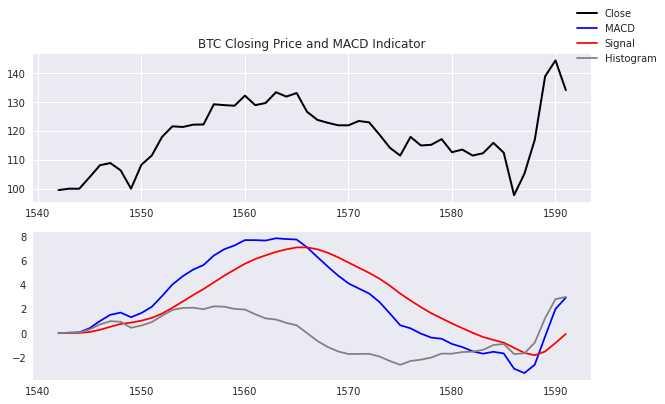

In [26]:
import matplotlib.pyplot as plt
# Plot the MACD indicator
plt.style.use("seaborn")
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(10, 6)
axs[0].plot(df["Close"][-50:], label="Close", color="black", lw=2)
axs[0].set_title("BTC Closing Price and MACD Indicator")
axs[1].plot(df["macd"], label="MACD", color="blue")
axs[1].plot(df["macd_signal"], label="Signal", color="red")
axs[1].plot(df["macd_hist"], label="Histogram", color="gray")
plt.grid()
fig.legend()